In [58]:
import math
import mesa
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Resource Classes

In [2]:
# create resource class - sugar
class Sugar(mesa.Agent):
    '''
    Sugar: 
    - contains an amount of sugar
    - creates a unit of sugar per turn
    '''
    def __init__(self, unique_id, model, pos, max_sugar):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar
        self.max_sugar = max_sugar

    def step(self):
        '''
        Sugar growth function: adds one unit of sugar for each step until we reach the max sugar value
        '''
        self.amount = min([self.max_sugar, self.amount + 1])
        #print(self.unique_id, self.amount, self.max_sugar)

In [3]:
# create resource class - spice
class Spice(mesa.Agent):
    '''
    Spice: 
    - contains an amount of spice
    - creates a unit of spice per turn
    '''
    def __init__(self, unique_id, model, pos, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice

    def step(self):
        '''
        Spice growth function: adds one unit of sugar for each step until we reach the max sugar value
        '''
        self.amount = min([self.max_spice, self.amount + 1])

# Helper Functions

In [17]:
def get_distance(pos1, pos2):
    '''
    Get euclidean distance between 2 sets of x, y coords
    Used in trader.move()
    '''
    x1, y1 = pos1
    x2, y2 = pos2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    '''
    Extracts lists from nested list and returns a single list
    Helper function for model datacollector for trade price
    '''
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
    '''
    Find the geometric mean from a list of prices
    Helper function for model datacollector for trade price
    '''
    return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
    '''
    Checks if agent is an object
    Filters agents to return trade partners
    Helper function for agent datacollector
    '''
    if type(agent) == Trader:
        return agent.trade_partners
    else: return None


# Trader Class

In [41]:
# create agent class - trader
class Trader(mesa.Agent):
    '''
    Trader: 
    - has a metabolism for sugar & spice
    - harvest and trades sugar & spice to thrive and survive
    '''
    def __init__(self, 
                 unique_id, 
                 model, 
                 pos, 
                 moore=False,
                 sugar=0,
                 spice=0,
                 metabolism_sugar = 0, 
                 metabolism_spice = 0,
                 vision = 0
                ):
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []

    def calculate_MRS(self, sugar, spice):
        '''
        Helper function for trade()
        MRS: determines what agent needs and what it will give up
        '''
        return (spice / self.metabolism_spice) / (sugar / self.metabolism_sugar)
    
    def is_starved(self):
        '''
        Helper function used in maybe_die()
        '''
        return (self.sugar <= 0) or (self.spice <= 0)
        
    def get_sugar(self, pos):
        '''
        Used in self.move() as part of get_sugar_amount
        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
        return None
        
    def get_spice(self, pos):
        '''
        Used in self.move() as part of get_spice_amount
        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Spice:
                return agent
        return None
    
    def get_spice_amount(self, pos):
        '''
        Used in self.move() as part of self.calculate_welfare
        '''
        spice_patch = self.get_spice(pos)
        if spice_patch:
            return spice_patch.amount
        return 0
    
    def get_sugar_amount(self, pos):
        '''
        Used in self.move() as part of self.calculate_welfare()
        '''
        sugar_patch = self.get_sugar(pos)
        if sugar_patch:
            return sugar_patch.amount
        return 0

    def calculate_welfare(self, sugar, spice):
        '''
        Helper function part 2 of self.move()
        Uses Cobb-Douglas function
        Used in self.trade()
        '''
        #calculate total resources
        m_total = self.metabolism_sugar + self.metabolism_spice

        #Cobb-Douglas functional form
        return sugar**(self.metabolism_sugar/m_total) * spice**(self.metabolism_spice/m_total) 

    def is_occupied_by_other(self, pos):
        '''
        Helper function part 1 of self.move()
        '''

        if pos == self.pos:
            #agent's position is considered unoccupied as agent can stay there
            return False
        #get contents of each cell in the neighborhood
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for a in this_cell:
            #see if cell is occupied by another agent
            if isinstance(a, Trader): 
                return True
        return False

    def get_trader(self, pos):
        '''
        Gets all traders in neighboring cells.
        Helper function in trade_with_neighbors()
        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent

    def calculate_sell_spice_amount(self, price):
        '''
        helper function for self.maybe_sell_spice()
        '''
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice

    def sell_spice(self, other, sugar, spice):
        '''
        Helper function used in maybe_sell_spice()
        Exchanges sugar and spice between traders
        '''
        self.sugar += sugar
        self.spice -= spice
        other.sugar -= sugar
        other.spice += spice
    
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        '''
        helper function for self.trade()
        '''
        sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

        #assess new sugar & spice amounts - what change did occur?
        self_sugar = self.sugar + sugar_exchanged
        other_sugar = other.sugar - sugar_exchanged
        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged

        #double-check that both agents have resources to complete trade
        if ((self_sugar <= 0) or 
            (other_sugar <= 0) or 
            (self_spice <= 0) or 
            (other_spice <= 0)):
            return False

        #trade criteria #1: are the agents better off?
        both_agents_better_off = (
            welfare_self < self.calculate_welfare(self_sugar, self_spice) and
                                  (welfare_other < other.calculate_welfare(other_sugar, other_spice))
        )
        #trade criteria #2: are MRS crossing?
        mrs_not_crossing = self.calculate_MRS(self_sugar, self_spice) > other.calculate_MRS(other_sugar, other_spice)

        if not(both_agents_better_off and mrs_not_crossing):
            return False

        #criteria met, execute trade
        self.sell_spice(other, sugar_exchanged, spice_exchanged)
        return True
            
    def trade(self, other):
        '''
        Sets Traders's ability to trade with neighboring Traders
        Used in trade_with_neighbors()
        '''
        #sanity check to ensure code is working as expected
        assert self.sugar > 0
        assert self.spice > 0
        assert other.sugar > 0
        assert other.spice > 0

        #calculate marginal rate of substitution for each commodity
        mrs_self = self.calculate_MRS(self.sugar, self.spice)
        mrs_other = other.calculate_MRS(other.sugar, other.spice)

        #calculate welfare of trading agents
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other = other.calculate_welfare(other.sugar, other.spice)

        if math.isclose(mrs_self, mrs_other):
            return
        #calculate price based on MRS, Building Artificial Societies p. 97
        price = math.sqrt(mrs_self * mrs_other)

        if mrs_self > mrs_other: # self is a sugar buyer and spice seller
            sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
            #no trade - criteria not met
            if not sold:
                    return
        else:
            #self is a spice buyer and a sugar seller
            sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
            #no trade - criteria not met
            if not sold:
                return

        #capture data
        self.prices.append(price)
        self.trade_partners.append(other.unique_id)

        #recursively keep trading
        self.trade(other)
        
    #######################################################################
    ###################### Helper Functions Above #########################
    #######################################################################
    
    def move(self):
        '''
        Function for the trader to ID the optimal move location for each step in 4 parts
        1 - ID all possible moves
        2 - ID which move will cause the maximum welfare
        3 - Find closest best option
        4 - Move
        '''
        #1. ID all possible moves
        neighbors = [i for i in self.model.grid.get_neighborhood(
            self.pos, self.moore, True, self.vision
        ) if not self.is_occupied_by_other(i)]

        #2. ID which move maximizes welfare
        welfares = [
            self.calculate_welfare(self.sugar + self.get_sugar_amount(pos), self.spice + self.get_spice_amount(pos)) for pos in neighbors
            ]

        #3. Finding the closest best option
        #finding highest welfare in welfares
        max_welfare = max(welfares)
        #get the index of max welfare cells
        candidate_indices = [
            i for i in range(len(welfares)) if math.isclose(welfares[i], max_welfare)
                            ]
        #convert index to positions of those cells
        candidates = [neighbors[i] for i in candidate_indices]

        min_dist = min(get_distance(self.pos, pos) for pos in candidates)

        final_candidates = [pos for pos in candidates if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol = 1e-02)]

        self.random.shuffle(final_candidates)

        #4. Move agent
        self.model.grid.move_agent(self, final_candidates[0])

    def eat(self):
        '''
        Enables the agent to consume sugar and spice,
        in line with its metabolism
        '''
        #get sugar
        sugar_patch = self.get_sugar(self.pos)
        if sugar_patch:
            self.sugar += sugar_patch.amount
            sugar_patch.amount = 0
        #eat sugar
        self.sugar -= self.metabolism_sugar

        #get spice
        spice_patch = self.get_spice(self.pos)
        if spice_patch:
            self.spice += spice_patch.amount
            spice_patch.amount = 0
        #eat spice
        self.spice -= self.metabolism_spice

    def maybe_die(self):
        '''
        Determines if a trader has died, and, if so, removes
        it from the model grid and scheduler
        '''
        if self.is_starved():
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    def trade_with_neighbors(self):
        '''
        Function that enables traders to decide who to trade with.
        Broken into 3 parts:
        1. ID neighbors who can trade
        2. Trading 
        3. Collect data about the trade
        '''
        #1. ID neighbors who can trade
        neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
            self.pos,
            self.moore,
            False,
            self.vision) if self.is_occupied_by_other(pos)
                          ]        
        if len(neighbor_agents) == 0:
            return
            
        #2. Trade
        #iterate through traders in neighborhood_agents and trade
        for a in neighbor_agents:
            if a:
                self.trade(a)
        return
                

# Model Class

In [56]:
# create a model class
class SugarscapeG1mt(mesa.Model):
    '''
    A model class to manage sugarscape with Traders (G1mt)
    from the book 'Growing Artificial Societies (Axtell & Epstein, 1996)
    '''
    def __init__(self, width=50, height=50, initial_population = 200,
                endowment_min = 25, endowment_max = 50, metabolism_min = 1,
                metabolism_max = 5, vision_min = 1, vision_max = 5):

        super().__init__()
        # Initiate dimensions of model class
        self.width = width
        self.height = height
        #Initiate population attributes
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        self.running = True #important for batch runs - prevents perpetual running

        # Instantiate scheduler
        self.schedule = mesa.time.RandomActivationByType(self)

        # Initiate grid environment
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus = False)

        # Inititiate data collector
        #lambda m calls model obejct
        self.datacollector = mesa.DataCollector(
            model_reporters = {"Trader" : lambda m: m.schedule.get_type_count(Trader),
             "Trade Volume": lambda m: sum(len(a.trade_partners) for a in m.schedule.agents_by_type[Trader].values()),
             "Price" : lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))
            },
            agent_reporters = {"Trade Network": lambda a: get_trade(a)}
        )

        # Read in landscape file from supplementary material
        sugar_distribution = np.genfromtxt("sugar-map.txt")
        spice_distribution = np.flip(sugar_distribution, 1)
        #plt.imshow(spice_distribution, origin = "lower")
        agent_id = 0
        
        for _, (x,y) in self.grid.coord_iter():
            max_sugar = sugar_distribution[x,y]
            if max_sugar > 0:
                sugar = Sugar(agent_id, self, (x, y), max_sugar)
                self.schedule.add(sugar)
                self.grid.place_agent(sugar, (x,y))
                #print(self.schedule.agents_by_type[Sugar][agent_id])
                agent_id += 1
            
            max_spice = spice_distribution[x,y]
            if max_spice > 0:
                spice = Spice(agent_id, self, (x,y), max_spice)
                self.schedule.add(spice)
                self.grid.place_agent(spice,(x,y))
                #print(self.schedule.agents_by_type[Spice][agent_id])
                agent_id += 1
        
        for i in range(self.initial_population):
            #get agent position
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            #give agents initial endowment
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max))
            #set agents' initial metabolism
            metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max))
            metabolism_spice= int(self.random.uniform(self.metabolism_min, self.metabolism_max))
            #give agents vision
            vision = int(self.random.uniform(self.vision_min, self.vision_max))

            #create Trader object
            trader = Trader(agent_id, self, (x,y), moore = False, 
                            sugar = sugar, 
                            spice = spice, 
                            metabolism_sugar = metabolism_sugar, 
                            metabolism_spice = metabolism_spice, 
                            vision = vision
                           )
            #place agent
            self.grid.place_agent(trader, (x,y))
            self.schedule.add(trader)
            #print(trader.unique_id, trader.pos, trader.sugar, trader.metabolism_spice)
            agent_id += 1
    
    def randomize_traders(self):
        '''
        Creates a random list of traders
        Used in step()
        '''
        trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
        self.random.shuffle(trader_shuffle)

        return trader_shuffle
        
    def step(self):
        '''
        Unique step function that does staged activation of sugar and spice
        and then randomly activates traders.
        '''
        #step sugar agents
        for sugar in self.schedule.agents_by_type[Sugar].values():
            sugar.step()
            
        #step spice agents
        for spice in self.schedule.agents_by_type[Spice].values():
            spice.step()

        #step trader agents
        #to account for agent death & removal, which would result in runtime error
        #if left in a dictionary
        
        trader_shuffle = self.randomize_traders()

        for agent in trader_shuffle:
            agent.prices = []
            agent.trade_partners = []
            agent.move()
            agent.eat()
            agent.maybe_die()
        
        trader_shuffle = self.randomize_traders()

        for agent in trader_shuffle:
            agent.trade_with_neighbors()  
            
        #advance the scheduler, which is important for the data collector
        self.schedule.steps += 1

        #collect model-level data
        self.datacollector.collect(self)

    def run_model(self, step_count = 1000):

        for i in range(step_count):
            self.step()

# Run model

In [43]:
model = SugarscapeG1mt()
model.run_model(step_count = 1000)
    

/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/1261281051.py:59: UserWarning: Agent 0 is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(spice,(x,y))
/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/1261281051.py:59: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(spice,(x,y))
/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/1261281051.py:59: UserWarning: Agent 2 is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(spice,(x,y))
/var/folders/m4/

# Analyze Model Data

In [21]:
#produce a PD dataframe of results
results = model.datacollector.get_model_vars_dataframe()
results

,Trader,Trade Volume,Price
0,200,201,1.004146
1,200,84,1.165778
2,200,111,1.021413
3,200,115,0.975336
4,200,98,0.816559
...,...,...,...
995,77,5,1.173213
996,77,5,0.981673
997,77,10,1.139224
998,77,12,1.067381


<Axes: >

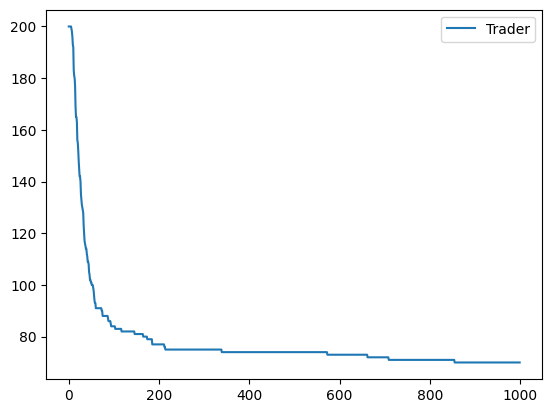

In [9]:
#plot number of agents at each timestep
results.plot(y = "Trader", use_index = True)

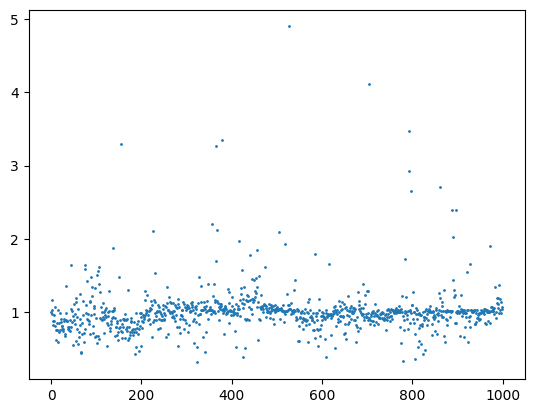

In [22]:
#plot trade prices
y = list(results["Price"])
x = range(1000)

plt.scatter(x, y, s=1)

<BarContainer object of 1000 artists>

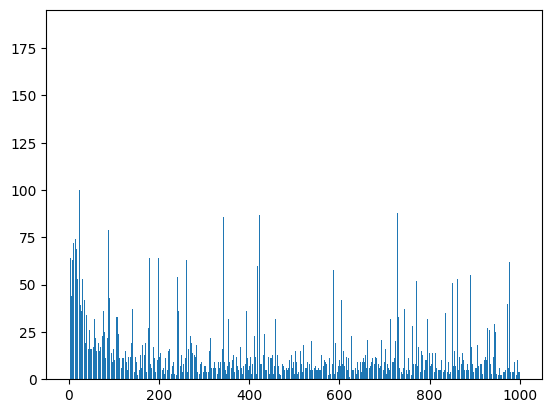

In [11]:
#plot trade volume
plt.bar(results.index, results["Trade Volume"]) #note that matplotlib might not be displaying this best (containers pick & choose)

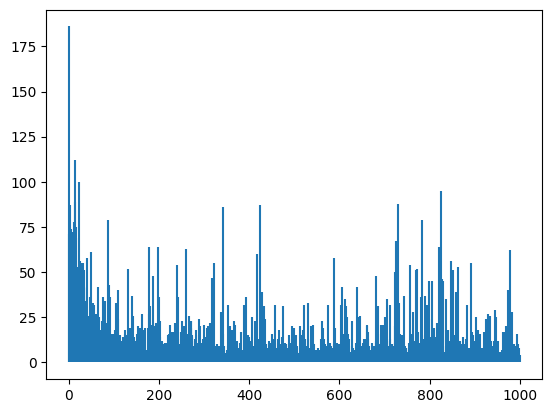

In [12]:
#plot trade volume - IMPROVED
for i in range(1000):
    plt.vlines(i, 0, results["Trade Volume"][i])

# Analyze Agent Data

In [44]:
#retrieve agent-level results
agent_results = model.datacollector.get_agent_vars_dataframe()

#filter out Nones from df
agent_results = agent_results[agent_results["Trade Network"].notnull()]
agent_results

Trade Network
Step AgentID              
0    4140     [4160, 4160]
     4141               []
     4143               []
     4145               []
     4146               []
...                    ...
     4325               []
     4326               []
     4331               []
     4332               []
     4337               []

[88 rows x 1 columns]

In [45]:
#add network instance to fill with network of traders
G = nx.Graph()

#add agent keys to make initial node set
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))

#create edge list to link nodes based on trading activity
for idx, row in agent_results.iterrows():
    if len(row["Trade Network"]) > 0:
        for agent in row["Trade Network"]:
            G.add_edge(idx[1], agent)

/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/405185087.py:5: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))


In [ ]:
nx.node_connectivity(G), nx.average_clustering(G), nx.diameter(G), nx.global_efficiency(G)

(array([73.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

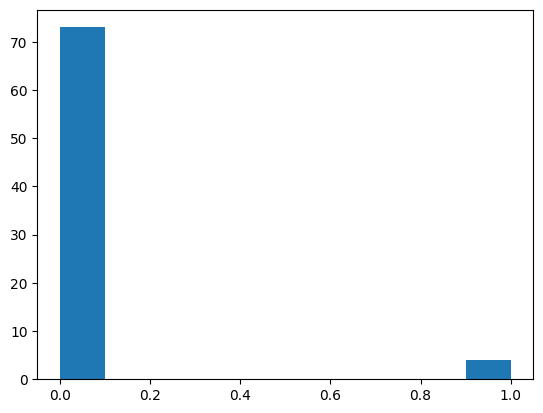

In [26]:
degree = [d for n, d in G.degree()]
plt.hist(degree)

In [ ]:
nx.draw(G)

# Batch Run and Analysis

In [57]:
params = {
    "width" : 50,
    "height" : 50,
    "vision_min" : range(1,3),
    "metabolism_max" : [3,5]
}

results_batch = mesa.batch_run(
    SugarscapeG1mt, 
    parameters = params,
    iterations = 1,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)


  0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/620414229.py:60: UserWarning: Agent 0 is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(spice,(x,y))
/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/620414229.py:60: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(spice,(x,y))
/var/folders/m4/34llc4tn50zcb3pv890d4c4r0000gn/T/ipykernel_20856/620414229.py:60: UserWarning: Agent 2 is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(spice,(x,y))
/var/folders/m4/34l

In [59]:
results_df = pd.DataFrame(results_batch)
results_df

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,356,0.976160,0.0,None
1,0,0,0,50,50,1,3,200,356,0.976160,1.0,None
2,0,0,0,50,50,1,3,200,356,0.976160,2.0,None
3,0,0,0,50,50,1,3,200,356,0.976160,3.0,None
4,0,0,0,50,50,1,3,200,356,0.976160,4.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
21101,3,0,996,50,50,2,5,107,7,0.995812,NaN,NaN
21102,3,0,997,50,50,2,5,107,13,1.060686,NaN,NaN
21103,3,0,998,50,50,2,5,107,9,1.135256,NaN,NaN
21104,3,0,999,50,50,2,5,107,15,1.088990,NaN,NaN


In [64]:
plt.scatter(results_df["Step"], results_df["Price"])

In [66]:
results_explore = results_df[results_df["metabolism_max"] == 3] #subset df to examine certian experimental conditions
results_explore

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,356,0.976160,0.0,None
1,0,0,0,50,50,1,3,200,356,0.976160,1.0,None
2,0,0,0,50,50,1,3,200,356,0.976160,2.0,None
3,0,0,0,50,50,1,3,200,356,0.976160,3.0,None
4,0,0,0,50,50,1,3,200,356,0.976160,4.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
15856,2,0,996,50,50,2,3,189,55,1.009936,NaN,NaN
15857,2,0,997,50,50,2,3,189,31,0.854455,NaN,NaN
15858,2,0,998,50,50,2,3,189,65,0.962004,NaN,NaN
15859,2,0,999,50,50,2,3,189,128,1.042041,NaN,NaN


In [67]:
plt.scatter(results_explore["Step"], results_explore["Price"])

In [73]:
for i in range(4):
    results_explore = results_df[results_df["RunId"] == i]
    plt.plot(results_explore["Step"], results_explore["Trader"])